In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
import zipfile


zip_path = "/content/archive (11).zip"
extract_path = "/content/extracted_files"  


with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)  
    print("Extracted files:", z.namelist()) 

Extracted files: ['fraudTest.csv', 'fraudTrain.csv']


In [ ]:
import pandas as pd
import os


csv_filename = [f for f in os.listdir(extract_path) if f.endswith('.csv')][0]  
csv_path = os.path.join(extract_path, csv_filename) 


df = pd.read_csv(csv_path)

# Display first 5 rows
print(df.head())

   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category    amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net   4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos 107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment 220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport  45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos  41.96      Tyler   

      last gender                        street  ...   lat    long  city_pop  \
0    Banks      F                561 Perry Cove  ... 36.08  -81.18      3495   
1     Gill      F  43039 Riley Greens Suite 393  ...

In [ ]:
print(df.isnull().sum())

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


is_fraud
0    1289169
1       7506
Name: count, dtype: int64


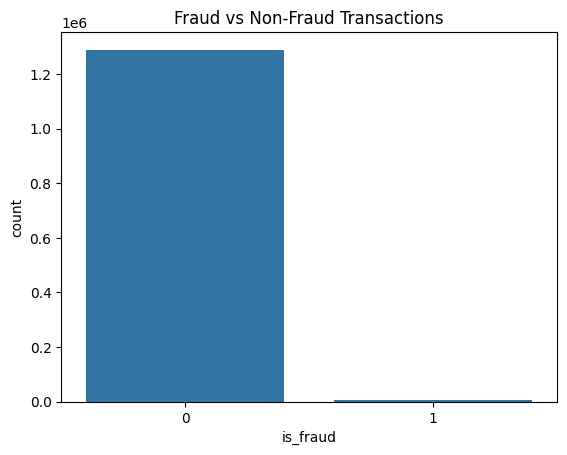

In [ ]:
print(df["is_fraud"].value_counts())

sns.countplot(x=df["is_fraud"])
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

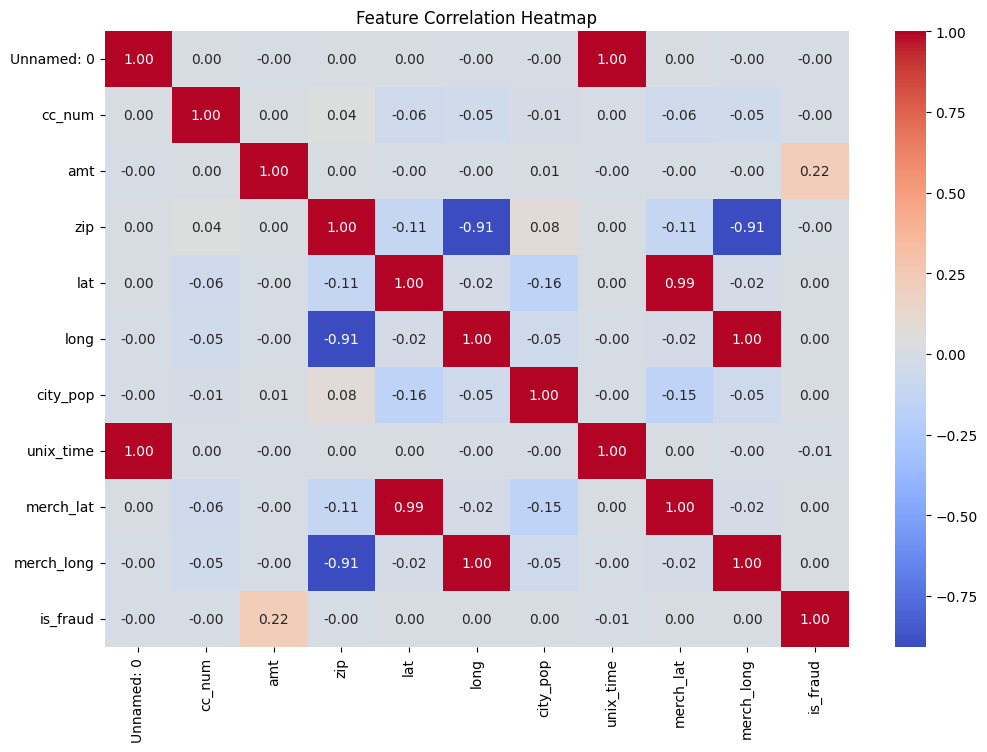

In [ ]:
df_numeric = df.select_dtypes(include=['number'])  
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


Top 10 Important Features based on Correlation:
       Feature  Correlation
0         amt         0.22
1   unix_time         0.01
2  Unnamed: 0         0.00
3         zip         0.00
4    city_pop         0.00
5         lat         0.00
6   merch_lat         0.00
7  merch_long         0.00
8        long         0.00
9      cc_num         0.00


<ipython-input-10-7e2040dff49e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Correlation", y="Feature", data=feature_importance_df.head(10), palette="coolwarm")


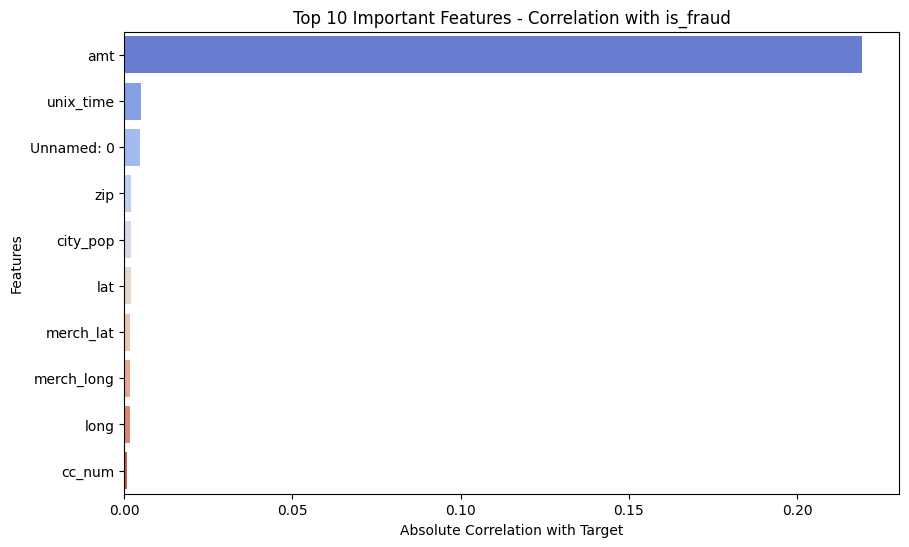

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


if 'df' not in locals() or df.empty:
    raise ValueError("Error: DataFrame 'df' is either undefined or empty.")

df_numeric = df.select_dtypes(include=['number'])
target_column = df_numeric.columns[-1]
correlation_matrix = df_numeric.corr()
if target_column in correlation_matrix.columns:

    feature_importance_corr = correlation_matrix[target_column].drop(target_column).abs()
    feature_importance_df = feature_importance_corr.sort_values(ascending=False).reset_index()
    feature_importance_df.columns = ["Feature", "Correlation"]
    print("Top 10 Important Features based on Correlation:\n", feature_importance_df.head(10))
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Correlation", y="Feature", data=feature_importance_df.head(10), palette="coolwarm")
    plt.xlabel("Absolute Correlation with Target")
    plt.ylabel("Features")
    plt.title(f"Top 10 Important Features - Correlation with {target_column}")
    plt.show()
else:
    print(f"Error: Target column '{target_column}' is missing from the correlation matrix.")


In [ ]:
df = df.drop(columns=["first", "last", "street", "city", "state", "zip", "dob", "trans_num"])

In [ ]:
from sklearn.preprocessing import LabelEncoder


for col in ["merchant", "category", "job", "gender"]:
    df[col] = LabelEncoder().fit_transform(df[col])

In [ ]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["hour"] = df["trans_date_trans_time"].dt.hour
df["day"] = df["trans_date_trans_time"].dt.day
df["month"] = df["trans_date_trans_time"].dt.month
df = df.drop(columns=["trans_date_trans_time", "unix_time"])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_cols = ["amt", "lat", "long", "city_pop", "merch_lat", "merch_long"]
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = df.drop(columns=["is_fraud"])
y = df["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(pd.Series(y_train_resampled).value_counts())

is_fraud
0    1031335
1     515667
Name: count, dtype: int64


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Train Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_resampled, y_train_resampled)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import classification_report, f1_score, accuracy_score


y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)


print("🔹Decision Tree Metrics:")
print(f" Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f" F1-Score: {f1_score(y_test, y_pred_dt):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("-" * 50)

print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("-" * 50)


🔹Decision Tree Metrics:
 Accuracy: 0.9804
 F1-Score: 0.3156
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    257834
           1       0.20      0.78      0.32      1501

    accuracy                           0.98    259335
   macro avg       0.60      0.88      0.65    259335
weighted avg       0.99      0.98      0.99    259335

--------------------------------------------------
Random Forest Metrics:
Accuracy: 0.9960
F1-Score: 0.6904
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.62      0.77      0.69      1501

    accuracy                           1.00    259335
   macro avg       0.81      0.89      0.84    259335
weighted avg       1.00      1.00      1.00    259335

--------------------------------------------------


In [ ]:
print(pd.Series(y_train_resampled).value_counts())

is_fraud
0    1031335
1     515667
Name: count, dtype: int64


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
rf_prob = rf.predict_proba(X_test)[:, 1]

In [ ]:

y_pred_rf = rf.predict(X_test)

In [ ]:
print("Random Forest F1-Score:", f1_score(y_test, y_pred_rf))

Random Forest F1-Score: 0.6904337492572786


In [ ]:
print("\nRandom Forest Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.62      0.77      0.69      1501

    accuracy                           1.00    259335
   macro avg       0.81      0.89      0.84    259335
weighted avg       1.00      1.00      1.00    259335



In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Train XGBoost model
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train_resampled, y_train_resampled)

# Make Predictions
y_pred_xgb = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)[:, 1]

# Evaluate XGBoost Model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost F1-Score:", f1_score(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:54:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9855746428364857
XGBoost F1-Score: 0.41077335013387933

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    257834
           1       0.27      0.87      0.41      1501

    accuracy                           0.99    259335
   macro avg       0.63      0.93      0.70    259335
weighted avg       0.99      0.99      0.99    259335



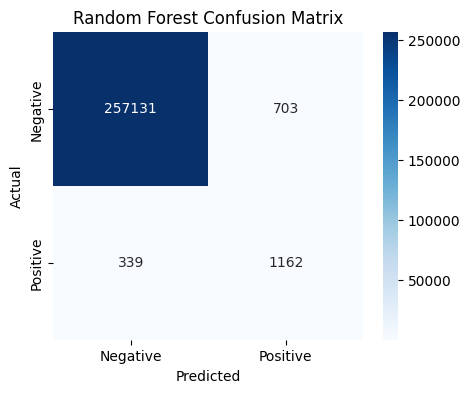

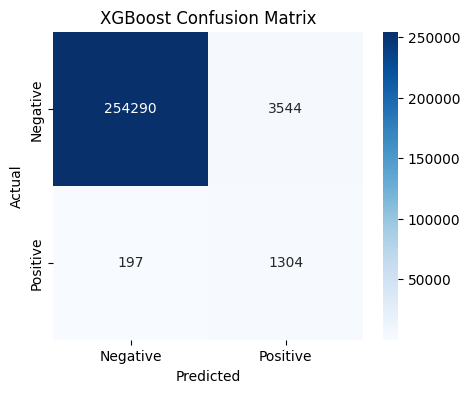

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import joblib
joblib.dump(rf, "Credit_Card_fraud_rf_model.pkl")
joblib.dump(xgb, "Credit_Card_fraud_xgb_model.pkl")
joblib.dump(scaler, "Credit_Card_scaler.pkl")



['Credit_Card_scaler.pkl']